In [ ]:
import torch
import sys
sys.path.append("../MAESTER/")
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from model import *
from utils import get_plugin, read_yaml
import numpy as np
from PIL import Image, ImageSequence
from torchvision.transforms import ToTensor
from infer_engine import run_inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download data

- Follow the instructions in README.md to download the test data, model weights and pre-computed k-means centers.

## Load trained model

- We use MAESTER default setting for demo.

In [2]:
config="default"
cfg = read_yaml(f"../MAESTER/configs/{config}.yaml")
model_weights = torch.load(f"../MAESTER/model_weights/{config}/model.pt", map_location="cpu")
kmeans_center = np.loadtxt(f"../MAESTER/model_weights/{config}/k6.txt")
storage_path = "./temp.pth" # path to save the intermediate results
K_CENTRE = 6
dataset_name = "c4"
data_path = f"../MAESTER/data/download/high_{dataset_name}/high_{dataset_name}_source.tif" #

In [3]:
model = get_plugin('model', cfg["MODEL"]["name"])(cfg["MODEL"])
model.load_state_dict(model_weights)
model.to(device)

img_size and patch_size configed
img_size: 80
patch_size: 5


MAESTER_MODEL(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 192, kernel_size=(5, 5), stride=(5, 5))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-13): 14 x Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=384, out_features=192, bias=True)
        (drop2): Dropout(p=0

- Load configs

In [4]:
vol_size = cfg["DATASET"]["vol_size"] + int(cfg["DATASET"]["vol_size"] // cfg["DATASET"]["patch_size"])  if cfg["DATASET"]["patch_size"] % 2 == 0 else cfg["DATASET"]["vol_size"]
TAR_SIZE = cfg["DATASET"]["vol_size"]
PATCH_size = cfg["DATASET"]["patch_size"]
OFFSET = PATCH_size // 2
PIX_SIZE = cfg["DATASET"]["patch_size"] + 1 if cfg["DATASET"]["patch_size"] % 2 == 0 else cfg["DATASET"]["patch_size"]
CENTRAL_PATCH = 4
PAD = int(OFFSET + ((((TAR_SIZE / PATCH_size) - CENTRAL_PATCH) // 2) * (PATCH_size + 1 if PATCH_size % 2==0 else PATCH_size)))
PAD = PAD + PIX_SIZE // 2

- Load test vEM slice and transform it to Tensor for faster computation.

In [5]:
image = Image.open(data_path)
tt = ToTensor()
count = 0
tensor_stack = []
for i, page in enumerate(ImageSequence.Iterator(image)):
    array = tt(page)
    tensor_stack.append(array)
    count += 1
result = torch.concat(tensor_stack, dim=0)
orgD, orgH, orgW = result.shape

## Inference

- In this demo, we infer two slices from dataset: 627 and 628.

In [6]:
# select two slices for inference
START, END = 627, 629
src = result[START:END]
srcD = src.shape[0]

rank = 0
ngpus_per_node = 1
run_inference(rank, ngpus_per_node, src, cfg, model, storage_path, device)

preparing tensor storage...

inferring batch #1 of 1
	 patch #1625 of 1625

Rank 0: Inference finished in  5.47 minutes.


- Original image

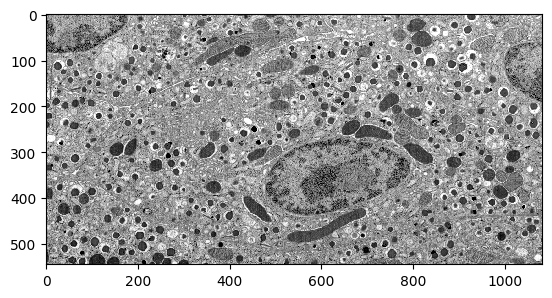

In [7]:
plt.imshow(np.array(src[0][:, : ].cpu()), interpolation='nearest',cmap='gray')
plt.show()

- load inferred embeddings

In [8]:
feature_storage = torch.FloatTensor(
    torch.from_file(
        storage_path, shared=True, size=srcD * (orgH+PAD) * (orgW+PAD) * cfg["MODEL"]["embed"]
    )
).reshape(srcD, orgH+PAD, orgW+PAD, cfg["MODEL"]["embed"])
feature_flattern = feature_storage[0, :orgH,:orgW,: ].flatten(0, -2).clone().numpy().astype(float)

- compute the k-means clusters

In [9]:
K_CENTRE = 6
kmeans = KMeans(n_clusters=K_CENTRE, random_state=2)
kmeans.cluster_centers_ = kmeans_center
kmeans._n_threads = 1
seg_pred = kmeans.predict(feature_flattern)
seg_pred[seg_pred == 0] = 4  # class merge

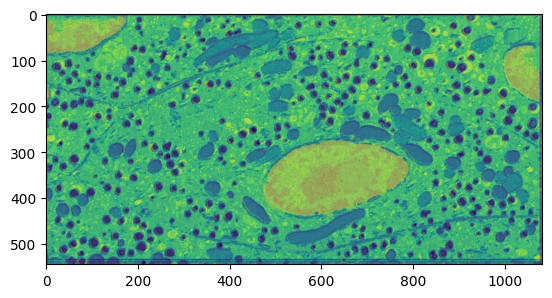

In [10]:
plt.imshow(np.array(src[0].cpu()), interpolation='bilinear')
plt.imshow(np.array(seg_pred.reshape(1, orgH , -1)[0]), alpha=0.5, 
           interpolation='bilinear')
plt.show()